- 참고 : https://sieon-dev.tistory.com/15

## 1. 모듈 import (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)
- pandas
- numpy
- matplotlib
- re
- konlpy
- tensorflow
- seaborn
- pandas_profiling

In [21]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas_profiling

In [41]:
import sklearn
from sklearn.model_selection import train_test_split

In [52]:
import collections
from collections import Counter

In [71]:
import exchange_calendars as ecals
import datetime
import time

### 1-1. 파이썬 & 모듈 버전 확인 (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)

In [74]:
print(" python version : ", sys.version, "\n", "-" * 100)
print(" pandas version : ", pd.__version__, "\n", "-" * 100)
print(" numpy version : ", np.__version__, "\n", "-" * 100)
print(" re version : ", re.__version__, "\n", "-" * 100)
print(" tensorflow version : ", tensorflow.__version__, "\n", "-" * 100)
print(" seaborn version : ", sns.__version__, "\n", "-" * 100)
print(" pandas_profiling version : ", pandas_profiling.__version__, "\n", "-" * 100)
print(" sklearn version : ", sklearn.__version__, "\n", "-" * 100)
print(" exhange_calendars version : ", ecals.__version__, "\n", "-" * 100)

 python version :  3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)] 
 ----------------------------------------------------------------------------------------------------
 pandas version :  1.2.4 
 ----------------------------------------------------------------------------------------------------
 numpy version :  1.20.1 
 ----------------------------------------------------------------------------------------------------
 re version :  2.2.1 
 ----------------------------------------------------------------------------------------------------
 tensorflow version :  2.3.0 
 ----------------------------------------------------------------------------------------------------
 seaborn version :  0.11.1 
 ----------------------------------------------------------------------------------------------------
 pandas_profiling version :  2.9.0 
 ----------------------------------------------------------------------------------------------------
 sklearn version :  0.24.1 
 --

### 1-2. 컴퓨터 사양 확인

![](2022-03-24-13-31-45.png)

## 2. 데이터 불러오기

In [91]:
# 뉴스데이터 불러오기
newsdata = pd.read_csv("../data/Newsfile3.csv", encoding='euc-kr')
newsdata.tail(3)

,date,title
58439,20151019,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,20151019,[반도체] 2016 반도체 투자 감소 예상 - 미래
58441,20151019,"제주반도체, '해외투자유치설' 조회공시 요구"


### 2-1. 휴장일 데이터 매칭

In [93]:
# newsdata의 datatype 확인
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  int64 
 1   title   58442 non-null  object
dtypes: int64(1), object(1)
memory usage: 913.3+ KB


- type 변환

In [94]:
# datatype : int -> string
newsdata = newsdata.astype({'date':'string'})
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  string
 1   title   58442 non-null  object
dtypes: object(1), string(1)
memory usage: 913.3+ KB


In [95]:
# datatype : string -> datetime
newsdata['date'] = pd.to_datetime(newsdata['date'])
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    58442 non-null  datetime64[ns]
 1   title   58442 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 913.3+ KB


- 뉴스데이터의 처음 날짜와 마지막 날짜 확인

In [96]:
first_date = newsdata['date'][0]
last_date = newsdata['date'][-1:]
print(first_date, last_date)

2022-03-16 00:00:00 58441   2015-10-19
Name: date, dtype: datetime64[ns]


In [97]:
# newsdata -> newsdata_all : 처음 날짜와 마지막 날짜가 포함된 데이터로 이름 변결
newsdata_all = newsdata[newsdata['date'].between('2015-10-19', '2022-03-16')]
newsdata_all

,date,title
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"
3,2022-03-16,"[특징주] 코리아써키트, 반도체 패키지기판 성장 기대감에 5%↑"
4,2022-03-16,"[특징주] 반도체 대장주 강세…SK하이닉스, 2% 넘게 상승"
...,...,...
58437,2015-10-19,세계 반도체 M&A 1006억달러
58438,2015-10-19,반도체社 인수·합병 봇물…올 들어 1000억달러 돌파
58439,2015-10-19,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,2015-10-19,[반도체] 2016 반도체 투자 감소 예상 - 미래


- 리스트로 변환

In [98]:
# 'date' 컬럼 리스트로 변경
news = newsdata_all['date'].to_list()
news[:5]

[Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00')]

### 2-2. 한국 거래소 개장일 확인

In [99]:
# 한국코드
XKRX = ecals.get_calendar("XKRX")       
# 2021-01-01은 개장일인지 확인 : 'False' -> 휴장일 , 'True' -> 개장일
print("2021-01-01 개장 확인: ", XKRX.is_session('2021-01-01'))    
# 오늘(22-03-24)은 개장일인지 확인 :'False' -> 휴장일 , 'True' -> 개장일
print("오늘날짜 개장일 확인: ", XKRX.is_session(datetime.date.today().strftime('%Y-%m-%d')))  
# 다음 개장일은 언제인지 확인
print("다음 개장일 날짜 확인: ", XKRX.next_open(pd.Timestamp.today().strftime('%Y-%m-%d')))

2021-01-01 개장 확인:  False
오늘날짜 개장일 확인:  True
다음 개장일 날짜 확인:  2022-03-25 00:00:00+00:00


In [100]:
# 뉴스데이터 날짜 다음날에 해당하는 개장일 날짜 확인
next_open_list = []

for day in news:
    next_open_date = XKRX.next_open(day)
    next_open_list.append(next_open_date)

In [101]:
next_open_list[:5]

[Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC')]

In [103]:
# 뉴스나온 날짜 다음 개장일 컬럼 추가
newsdata_all['NextOpenDate'] = next_open_list
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17 00:00:00+00:00
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17 00:00:00+00:00
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17 00:00:00+00:00


In [104]:
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          58442 non-null  datetime64[ns]     
 1   title         58442 non-null  object             
 2   NextOpenDate  58442 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(1)
memory usage: 1.8+ MB


- type 변환

In [105]:
newsdata_all = newsdata_all.astype({'NextOpenDate':'string'})
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  string        
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 1.8+ MB


In [106]:
a = newsdata_all['NextOpenDate'][0]
b = a.split(' ')[0]
b

'2022-03-17'

In [108]:
newsdata_all['NextOpenDate'] = newsdata_all['NextOpenDate'].apply(lambda x: x.split(' ')[0])
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17


In [109]:
newsdata_all['NextOpenDate'] = pd.to_datetime(newsdata_all['NextOpenDate'])
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 3.8+ MB


In [135]:
# 개장일 기준 'Year' 컬럼 추가
newsdata_all['NextOpenDateYear'] = newsdata_all['NextOpenDate'].dt.year
newsdata_all.head(3)

,date,NextOpenDate,title,NextOpenDateYear
0,2022-03-16,2022-03-17,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022
1,2022-03-16,2022-03-17,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022
2,2022-03-16,2022-03-17,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022


In [136]:
# col의 인덱스 변경
col = newsdata_all.columns.to_numpy()
col

array(['date', 'NextOpenDate', 'title', 'NextOpenDateYear'], dtype=object)

In [137]:
col = col[[0,1,3,2]]
col

array(['date', 'NextOpenDate', 'NextOpenDateYear', 'title'], dtype=object)

In [138]:
newsdata_all = newsdata_all[col]
newsdata_all.head(3)

,date,NextOpenDate,NextOpenDateYear,title
0,2022-03-16,2022-03-17,2022,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,2022-03-17,2022,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,2022-03-17,2022,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"


## 3. 데이터 확인

In [141]:
# 데이터 갯수 : 58442개
# 컬럼 갯수 : 2개
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              58442 non-null  datetime64[ns]
 1   NextOpenDate      58442 non-null  datetime64[ns]
 2   NextOpenDateYear  58442 non-null  int64         
 3   title             58442 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 4.2+ MB


In [142]:
# 결측치 확인
newsdata_all.isnull().sum()

date                0
NextOpenDate        0
NextOpenDateYear    0
title               0
dtype: int64

## 4. 기업별 '현재가', '당일종가-어제종가', '상승률', 'label' 데이터와 뉴스데이터 병합

## 5. train, test dataset 생성

In [143]:
# train, test set 분리
train_data, test_data = train_test_split(newsdata_all)

### 5-1. train_data

In [144]:
train_data.head(2)

,date,NextOpenDate,NextOpenDateYear,title
45709,2018-01-23,2018-01-24,2018,"""반도체 사이클, 상반기에 꺾인다"" vs ""올해까진 괜찮아"""
36038,2019-02-21,2019-02-22,2019,120조 반도체 클러스터 부지 용인으로 가닥


In [145]:
# train_data shape 확인
train_data.shape

(43831, 4)

### 5-2. test_data

In [146]:
# test_data 확인
test_data.head(2)

,date,NextOpenDate,NextOpenDateYear,title
22575,2020-06-15,2020-06-16,2020,美 中은 펄펄 나는데 고군분투하는 한국 반도체 산업
40375,2018-09-17,2018-09-18,2018,반도체 수출 호조로 ICT 수출액 사상 첫 200억달러 돌파


In [147]:
# test_data shape 확인
test_data.shape

(14611, 4)

### 5-3. countplot

- train_data

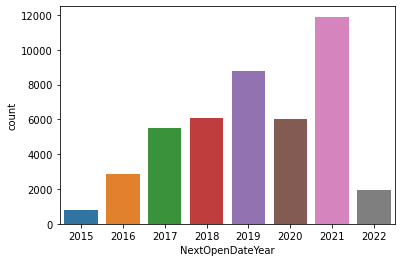

In [148]:
sns.countplot(x='NextOpenDateYear', data=train_data)
plt.show()

- test_data

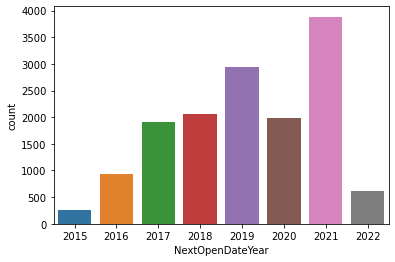

In [149]:
sns.countplot(x='NextOpenDateYear', data=test_data)
plt.show()

## 6. 데이터 전처리

### 6-1. train_data

In [125]:
# 한글과 띄어쓰기 이외의 문자열 제거
train_data['title'] = train_data['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

In [126]:
# '' 만 남은 데이터 --> np.nan으로 변경시킨 후 제거
train_data['title'].replace('', np.nan, inplace=True)
train_data['title'].isna().sum()

0

In [128]:
# Null 데이터 제거
train_data.dropna(how='any', inplace=True)
train_data.shape

(43831, 3)

### 6-2. test_data

In [150]:
# 한글과 띄어쓰기 이외의 문자열 제거
test_data['title'] = test_data['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

In [151]:
# '' 만 남은 데이터 --> np.nan으로 변경시킨 후 제거
test_data['title'].replace('', np.nan, inplace=True)
test_data['title'].isna().sum()

0

In [152]:
# Null 데이터 제거
test_data.dropna(how='any', inplace=True)
test_data.shape

(14611, 4)